## 1 数据集介绍

文件 `./input/out.opsahl-openflights.csv` 中的有向网络包含世界各机场之间的航班。有向边表示从一个机场到另一个机场的飞行航线。这个数据集是从Openflights.org 数据中提取出来的，与 Tore Opsahl 在数据集列表中的网络14c相对应，来源网址为：[toreopsahl.com](http://toreopsahl.com/datasets/#usairports)。

利用 `networkx` 中的 `read_edgelist` 函数，将网络加载到内存中。注意，由于我们处理的是有向网络，所以需要将 `create_using` 参数设置为 `nx.DiGraph()`。

In [6]:
import networkx as nx
flights_network = nx.read_edgelist("./input/out.opsahl-openflights.csv",create_using=nx.DiGraph())

In [7]:
print("航班数：" + str(len(flights_network.nodes)))
print("航线数：" + str(len(flights_network.edges)))

航班数：2939
航线数：30501


在这个航线网络中，一共包含 2939 个机场，30501 条航线。下面我们使用 `nx.draw` 函数，将网络进行可视化。

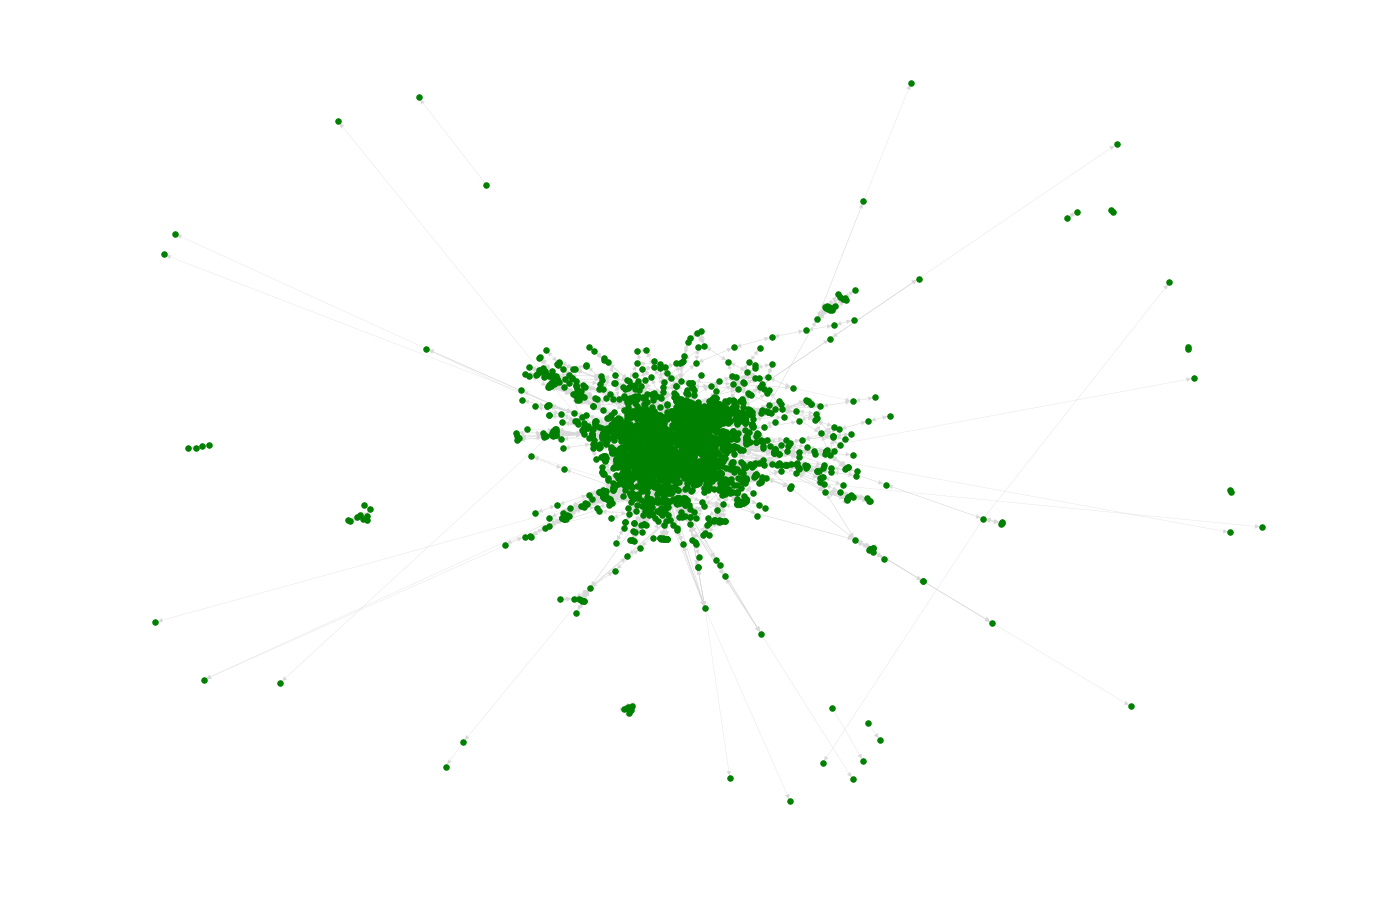

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(24, 16)) 
pos_flights = nx.kamada_kawai_layout(flights_network) #网络布局
ax.axis("off")
plt.box(False)
nx.draw(flights_network, node_size=30,node_color = "green", edge_color = "#D8D8D8",width=.3, ax=ax)

## 2 找出最大连通子图

从上图中很容易看出，这个网络不是一个连通图。我们从航线网络中提取出最大连通子图进行进一步分析。 对于有向网络， `networkx` 中的 `weakly_connected_component_subgraphs` 函数可以返回网络中的连通子图列表。我们只提取最大连通子图。

In [9]:
largest_component = max(nx.weakly_connected_component_subgraphs(flights_network), key=len)#找出最大连通子图

In [10]:
print("航班数：" + str(len(largest_component.nodes)))
print("航线数：" + str(len(largest_component.edges)))

航班数：2905
航线数：30442


在最大连通子图中，一共包含 2905 个机场和 30442 条航线。下面将最大连通子图进行可视化。

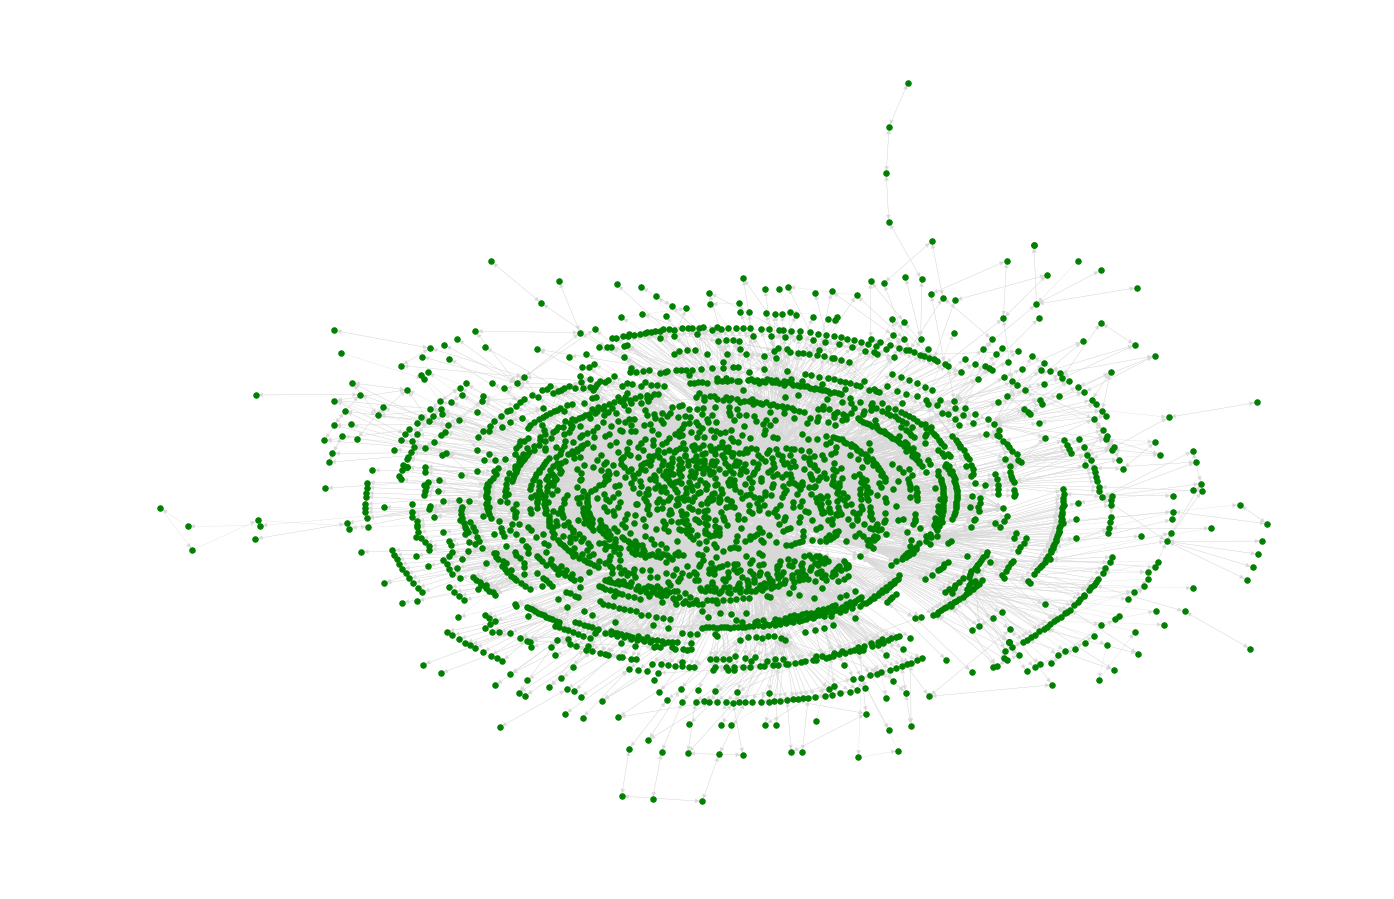

In [11]:
fig, ax = plt.subplots(figsize=(24, 16)) 
pos_flights2 = nx.kamada_kawai_layout(largest_component)
ax.axis("off")
plt.box(False)
nx.draw(largest_component, node_size=30,node_color = "green", edge_color = "#D8D8D8",width=.3,pos = pos_flights2, ax=ax)

## 3 PageRank 算法简介

PageRank算法是由谷歌创始人拉里·佩奇(Larry Page)和谢尔盖·布林(Sergey Brin)所设计出来的谷歌搜索引擎上的页面排序算法，最早作为论文发表于 1998 年。
论文发表之后没多久，佩奇和布林就以此论文为基础创立了谷歌公司。

PageRank是一个迭代算法。
在初始的时候，每个点的PageRank值都设置成$\frac{1}{|V|}$，其中$|V|$为图中点的数量。 
在每一轮的迭代中，每个点 $v$ 都沿着它的出边往它每个邻居点传递 $v$ 的 $\frac{1}{|\text{N}^{+}(v)}|$ 的PageRank值。
于是，经过第 $t+1$ 轮迭代之后，每个点 $v$ 的PageRank值可以表示为
$$
\text{PR}(v,t+1)=\frac{1-\beta}{|V|}+\beta\sum\limits_{u\in N^{-}(v)}\frac{\text{PR}(u,t)}{|N^{+}(u)|} .
$$
其中 $N^{-}(v)$ 为指向节点$v$的节点集合，而 $N^{+}(u)$ 表示 $u$ 指向的节点的集合。

![png](http://cookdata.cn/media/note_images/pagerank_1589332964064_5d14.jpg)

阻尼系数 $\beta$ 用来表示在PageRank迭代过程中一个点沿着出边跳转到下一个点的概率。
$(1 - \beta)$ 表示在浏览过程不沿着边跳转，而是在所有点中随机挑选下一个点的概率。
实际试验证明 $\beta$ 被设置成 $0.85$ 时 PageRank 的计算结果最符合实际情况。

## 4 使用 PageRank 算法对机场进行排序

在 `networkx` 中，使用 `pagerank` 函数即可计算网络中节点的 PageRank 值。

In [12]:
pr_dict = nx.pagerank(largest_component)

In [13]:
import pandas as pd
pr_df = pd.DataFrame.from_dict(pr_dict,orient="index")
pr_df.columns = ["pr_value"]
pr_df.sort_values(by = "pr_value").head(20)
pr_df.head(20)

,pr_value
1,0.000114
2,0.002315
3,0.000428
4,0.000421
5,0.000369
6,0.000350
7,0.000416
8,0.000202
9,0.000264
10,0.000255


## 5 将节点大小与 PageRank 值关联并可视化

实现一个函数 `get_nodesize_pagerank` ，将网络中节点的 PageRank 值，映射为网络中节点的大小。

In [14]:
def get_nodesize_pagerank(pagerank, min_size, max_size):
    nodesize_list = []
    pr_max = max(pagerank.values())
    for node, pr in pagerank.items():
        nodesize = (max_size - min_size)*pr/pr_max + min_size
        nodesize_list.append(nodesize)
    return nodesize_list

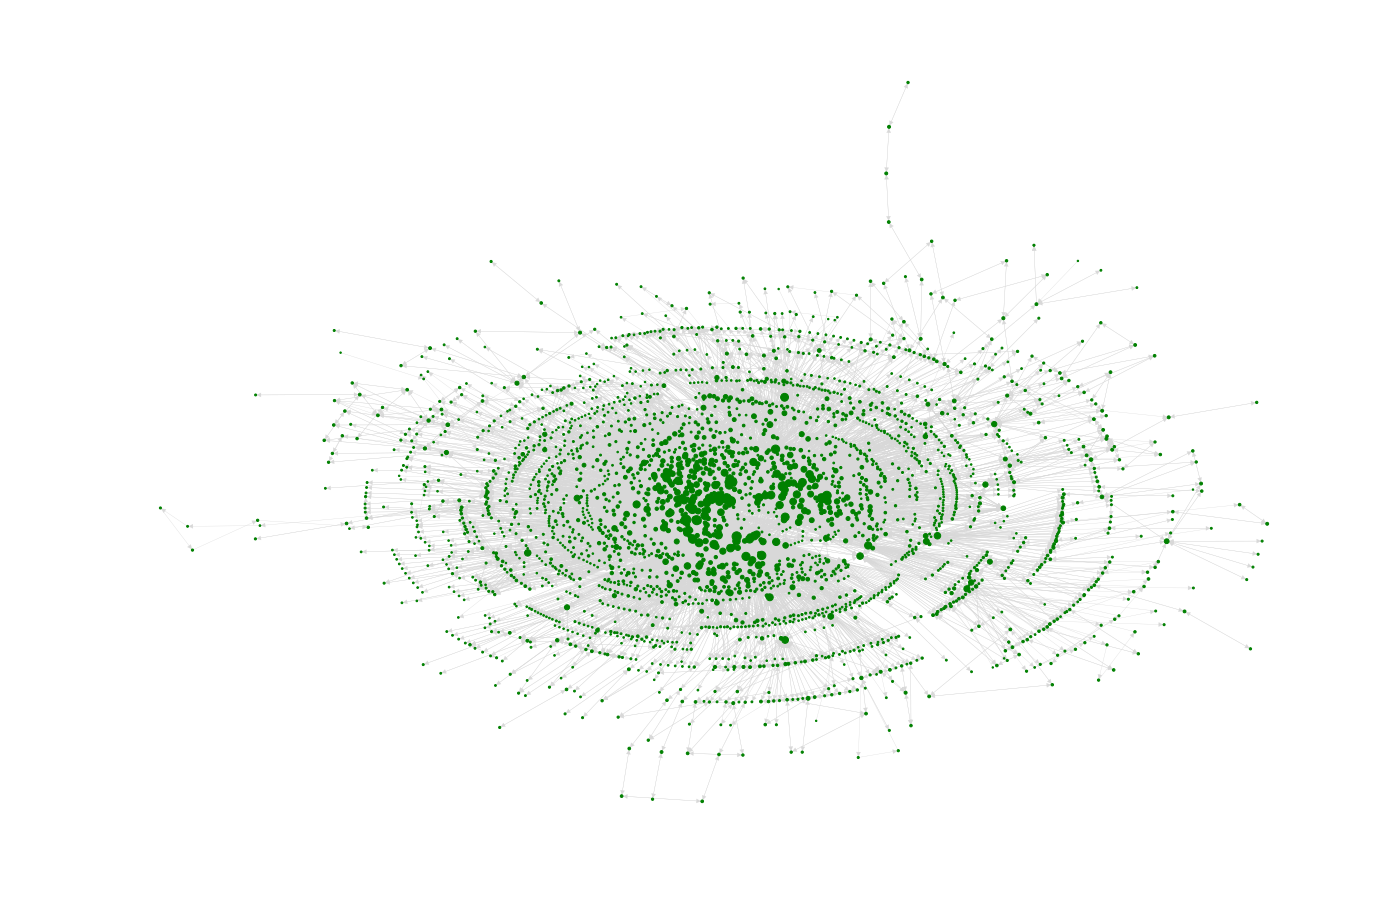

In [15]:
fig, ax = plt.subplots(figsize=(24, 16)) 
pos_flights2 = nx.kamada_kawai_layout(largest_component)
ax.axis("off")
plt.box(False)
nx.draw(largest_component, node_size=get_nodesize_pagerank(pr_dict,1,100),node_color = "green", edge_color = "#D8D8D8",width=.3,pos = pos_flights2, ax=ax)